In [ ]:
import pandas as pd
import os

# --- Configuration ---
GROUP_KEY_COLUMN = 'region'
data_path = "datafile.tsv"

# The value we want to check (now in lowercase to match the new logic)
group_value_to_check = "middle east and north africa"
category_to_check = 7

# --- Robust Verification Script ---
try:
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found at: '{data_path}'")

    data_df = pd.read_csv(data_path, sep="\t")
    data_df.columns = [c.strip() for c in data_df.columns]

    if GROUP_KEY_COLUMN not in data_df.columns:
        raise ValueError(f"Error: Column '{GROUP_KEY_COLUMN}' not found.")

    # --- NEW: Print all unique region names to see what's in the data ---
    print("--- Unique values found in the 'region' column ---")
    unique_regions = data_df[GROUP_KEY_COLUMN].dropna().unique()
    print(unique_regions)
    print("-" * 50 + "\n")
    # --------------------------------------------------------------------

    df_check = data_df.copy()
    df_check["category"] = pd.to_numeric(df_check["category"], errors="coerce")
    df_check[GROUP_KEY_COLUMN] = df_check[GROUP_KEY_COLUMN].astype(str).str.strip()

    # --- MODIFIED: Make the comparison case-insensitive ---
    filtered_df = df_check[
        (df_check[GROUP_KEY_COLUMN].str.lower() == group_value_to_check) &
        (df_check["category"] == category_to_check)
    ]
    # ------------------------------------------------------

    print(f"--- Verification for '{group_value_to_check}' | Category '{category_to_check}' (Moderation Labor) ---\n")

    if filtered_df.empty:
        print("Result: No records found for this combination even after ignoring case.")
        print("Please check the unique values printed above and adjust the 'group_value_to_check' variable if needed.")
    else:
        print("Found the following records in the original data:\n")
        print(filtered_df[['score', 'category', GROUP_KEY_COLUMN]].to_string())
        print("\n" + "="*50 + "\n")

        evaluation_count = len(filtered_df)
        all_scores_are_zero = filtered_df['score'].eq(0).all()

        print(f"Conclusion:")
        print(f"1. Total number of evaluations found: {evaluation_count}")
        print(f"2. Are all scores for these evaluations 0? -> {all_scores_are_zero}")

        if evaluation_count == 2 and all_scores_are_zero:
            print("\nThis confirms why the plot shows '0.0 (2)'.")
        else:
            print("\nThe data does not match the '0.0 (2)' case. Please review the records found.")

except (FileNotFoundError, ValueError) as e:
    print(e)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Unique values found in the 'region' column ---
['East Asia' 'Europe' 'North America' 'South and Central Asia'
 'Middle East and North Africa']
--------------------------------------------------

--- Verification for 'middle east and north africa' | Category '7' (Moderation Labor) ---

Found the following records in the original data:

      score  category                        region
468     0.0         7  Middle East and North Africa
475     0.0         7  Middle East and North Africa
867     0.0         7  Middle East and North Africa
1049    0.0         7  Middle East and North Africa
1070    0.0         7  Middle East and North Africa
1077    0.0         7  Middle East and North Africa


Conclusion:
1. Total number of evaluations found: 6
2. Are all scores for these evaluations 0? -> True

The data does not match the '0.0 (2)' case. Please review the records found.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.font_manager as fm
import subprocess
import os
import textwrap

# --- Font Setup ---
# Download and register Times New Roman (regular, bold, and italic)
font_files_to_download = {
    'TimesNewRoman.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf',
    'TimesNewRomanBold.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold.ttf',
    'TimesNewRomanItalic.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Italic.ttf'
}

# Create a directory for fonts if it doesn't exist
font_dir = '/content/fonts'
os.makedirs(font_dir, exist_ok=True)

for fname, url in font_files_to_download.items():
    font_path = os.path.join(font_dir, fname)
    if not os.path.exists(font_path):
        subprocess.run(['curl', '-L', url, '-o', font_path], capture_output=True, check=True)

# Register fonts with matplotlib
for font_path in fm.findSystemFonts(fontpaths=[font_dir], fontext='ttf'):
    fm.fontManager.addfont(font_path)

# --- Matplotlib Style Configuration ---
plt.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 300, "font.size": 11,
    "axes.titlesize": 20, "axes.labelsize": 15, "xtick.labelsize": 11,
    "ytick.labelsize": 11, "legend.fontsize": 16,
    "axes.spines.top": True, "axes.spines.left": True,
    "axes.spines.right": False, "axes.spines.bottom": False,
    "axes.titlepad": 6, "font.family": "Times New Roman",
    "mathtext.fontset": "custom",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold",
})

# --- Helper Functions ---
def _height_for_count_power_scaled(count_val, min_count, max_count, min_height, max_height, power=0.65):
    if count_val <= 0: return 0
    power_count_val = np.power(count_val, power)
    power_min_count = np.power(min_count, power)
    power_max_count = np.power(max_count, power)
    if power_max_count <= power_min_count: return min_height if count_val > 0 else 0
    scaled_height = (power_count_val - power_min_count) / \
                   (power_max_count - power_min_count) * \
                   (max_height - min_height) + min_height
    return max(min_height, scaled_height)

# --- Main Plotting Function ---
def create_rectangle_plot(group_key, title=None, y_label=None, fig_width=12, fig_height=None, row_gap=0.2,
                         separator_gap=0.5,
                         data_path="MAIN_ANNOTATIONS_MERGED.tsv",
                         min_rect_height=0.2, max_rect_height=0.6, rect_width=0.7,
                         power_scale=0.65,
                         plot_margins={'top': 0.88, 'bottom': 0.12, 'left': 0.15, 'right': 0.99},
                         wspace=0.05, aspect_ratio=None, provider_list=None,
                         show_quality_scores=True, y_label_wrap_width=15,
                         show_rect_borders=True, show_empty_cells=True):
    """
    Creates a rectangle plot with options to control spacing, borders, and empty cell visibility.
    """
    category_labels = {
        1: "Bias\n& Harm", 2: "Sensitive\nContent", 3: "Performance\nDisparity",
        4: "Env. Costs\n& Emissions", 5: "Privacy\n& Data", 6: "Financial\nCosts",
        7: "Moderation\nLabor", 8: "Overall\nAverage"
    }
    order_cats = list(range(1, 9))

    x_coords = list(range(7)) + [6 + 1 + separator_gap]
    x_map = {cat: x for cat, x in zip(order_cats, x_coords)}

    norm = plt.Normalize(vmin=0.0, vmax=3.0)
    colors = ['#F0F8FF', '#B0E0E6', '#87CEEB', '#4682B4', '#191970', '#000080']
    cmap = LinearSegmentedColormap.from_list('blue_gradient', colors, N=256)

    try:
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Data file not found at the specified path: '{data_path}'")
        data_df = pd.read_csv(data_path, sep="\t")
        data_df.columns = [c.strip() for c in data_df.columns]
    except Exception as e:
        raise Exception(f"Error loading or processing data file: {e}")

    df_clean = data_df.copy()
    df_clean["category"] = pd.to_numeric(df_clean["category"], errors="coerce")
    df_clean["score"] = pd.to_numeric(df_clean["score"], errors="coerce")
    df_clean = df_clean[
        df_clean["category"].isin(range(1, 8)) &
        df_clean["score"].between(0, 3, inclusive="both") &
        df_clean[group_key].notna()
    ].copy()
    df_clean[group_key] = df_clean[group_key].astype(str).str.strip()


    if df_clean.empty: raise ValueError("No valid data to plot after cleaning and filtering.")

    grouping_keys = ["provider", "name", "category"]
    if group_key not in grouping_keys: grouping_keys.append(group_key)
    model_cat = df_clean.groupby(grouping_keys, dropna=False).agg(model_eval_count=("score", "size"), model_avg_score=("score", "mean")).reset_index()

    if provider_list:
        model_cat = model_cat[model_cat[group_key].isin(provider_list)]

    unique_items = model_cat[group_key].dropna().unique()
    final_order = sorted(unique_items, key=str.lower)

    # --- MODIFIED: Replaced the buggy .apply() with a more robust method for weighted average ---
    # This is a standard way to compute a grouped weighted average.
    model_cat['score_x_count'] = model_cat['model_avg_score'] * model_cat['model_eval_count']
    main_plot_data_agg = model_cat.groupby([group_key, 'category']).agg(
        score_x_count_sum=('score_x_count', 'sum'),
        count=('model_eval_count', 'sum')
    ).reset_index()

    main_plot_data_agg['avg_score'] = main_plot_data_agg.apply(
        lambda row: row['score_x_count_sum'] / row['count'] if row['count'] > 0 else 0.0,
        axis=1
    )
    main_plot_data = main_plot_data_agg[[group_key, 'category', 'count', 'avg_score']]
    # --- END MODIFICATION ---

    full_index = pd.MultiIndex.from_product([final_order, range(1, 8)], names=[group_key, 'category'])
    complete_data = main_plot_data.set_index([group_key, 'category']).reindex(full_index, fill_value=0).reset_index()

    avg_data = complete_data.groupby(group_key).agg(count=('count', 'mean'), avg_score=('avg_score', 'mean')).reset_index()
    avg_data['category'] = 8

    plot_data = pd.concat([complete_data, avg_data], ignore_index=True)

    if not show_empty_cells:
        plot_data = plot_data[plot_data['count'] > 0].copy()

    all_counts = plot_data.loc[plot_data["count"] > 0, "count"]
    min_val, max_val = (1, all_counts.max()) if not all_counts.empty else (1, 1)

    empty_cell_height = 0.15
    def get_height(c):
        if c > 0:
            return _height_for_count_power_scaled(c, min_val, max_val, min_rect_height, max_rect_height, power_scale)
        return empty_cell_height if show_empty_cells else 0
    plot_data['height'] = plot_data['count'].apply(get_height)

    max_heights_per_row = plot_data.groupby(group_key)['height'].max()

    if final_order:
        all_max_heights = [max_heights_per_row.get(item, min_rect_height if not show_empty_cells else empty_cell_height) for item in final_order]
        total_content_height = sum(all_max_heights) + len(all_max_heights) * row_gap
    else:
        total_content_height = 1

    y_map = {}
    current_y = total_content_height - (row_gap * 0.5)
    for item in final_order:
        max_h = max_heights_per_row.get(item, min_rect_height if not show_empty_cells else empty_cell_height)
        y_map[str(item)] = current_y - max_h / 2.0
        current_y -= (max_h + row_gap)

    if fig_height is None:
        plot_area_ratio = plot_margins['top'] - plot_margins['bottom']
        fig_height = total_content_height / plot_area_ratio
        fig_height = max(4.5, fig_height)

    fig, ax_main = plt.subplots(figsize=(fig_width, fig_height))
    fig.subplots_adjust(**plot_margins)

    edge_color = 'k' if show_rect_borders else 'none'

    for _, row in plot_data.iterrows():
        if str(row[group_key]) in y_map:
            x_pos, y_pos = x_map.get(row['category']), y_map[str(row[group_key])]
            # Ensure x_pos is valid before proceeding
            if x_pos is None: continue

            height, score = row['height'], row['avg_score']
            color = cmap(norm(score))

            rect = Rectangle((x_pos - rect_width/2, y_pos - height/2), rect_width, height,
                             facecolor=color, edgecolor=edge_color, alpha=0.7, zorder=2)

            ax_main.add_patch(rect)

            if show_quality_scores:
                text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
                score_fmt = "{:.2f}" if row['category'] == 8 else "{:.1f}"
                score_str = score_fmt.format(score)
                count_val = int(row['count']) if row['category'] == 8 else int(round(row['count']))
                count_str = f"({count_val})"
                text = rf"$\mathbf{{{score_str}}}$ $\mathit{{{count_str}}}$"
                ax_main.text(x_pos, y_pos, text, ha='center', va='center', fontsize=9, color=text_color, zorder=3)

    ax_main.set_xticks(list(x_map.values()))
    ax_main.set_xticklabels([category_labels[c] for c in order_cats], fontweight='bold')

    ax_main.set_yticks([y_map[str(g)] for g in final_order])
    wrapped_labels = []
    for label in final_order:
        processed_label = label.title()
        if processed_label.lower().endswith('ai'): processed_label = processed_label[:-2] + 'AI'
        wrapped_labels.append(textwrap.fill(processed_label, width=y_label_wrap_width))
    ax_main.set_yticklabels(wrapped_labels, fontweight='bold')

    ax_main.xaxis.tick_top()
    ax_main.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True, length=0)
    ax_main.tick_params(axis='y', which='both', right=False, length=0)

    ax_main.set_xlim(-0.5, x_coords[-1] + 0.5)
    ax_main.set_ylim(0, total_content_height)

    separator_x_pos = (x_map[7] + x_map[8]) / 2.0
    ax_main.axvline(x=separator_x_pos - 0.02, color='black', linewidth=2.5, zorder=10)
    ax_main.axvline(x=separator_x_pos + 0.02, color='black', linewidth=2.5, zorder=10)

    return fig

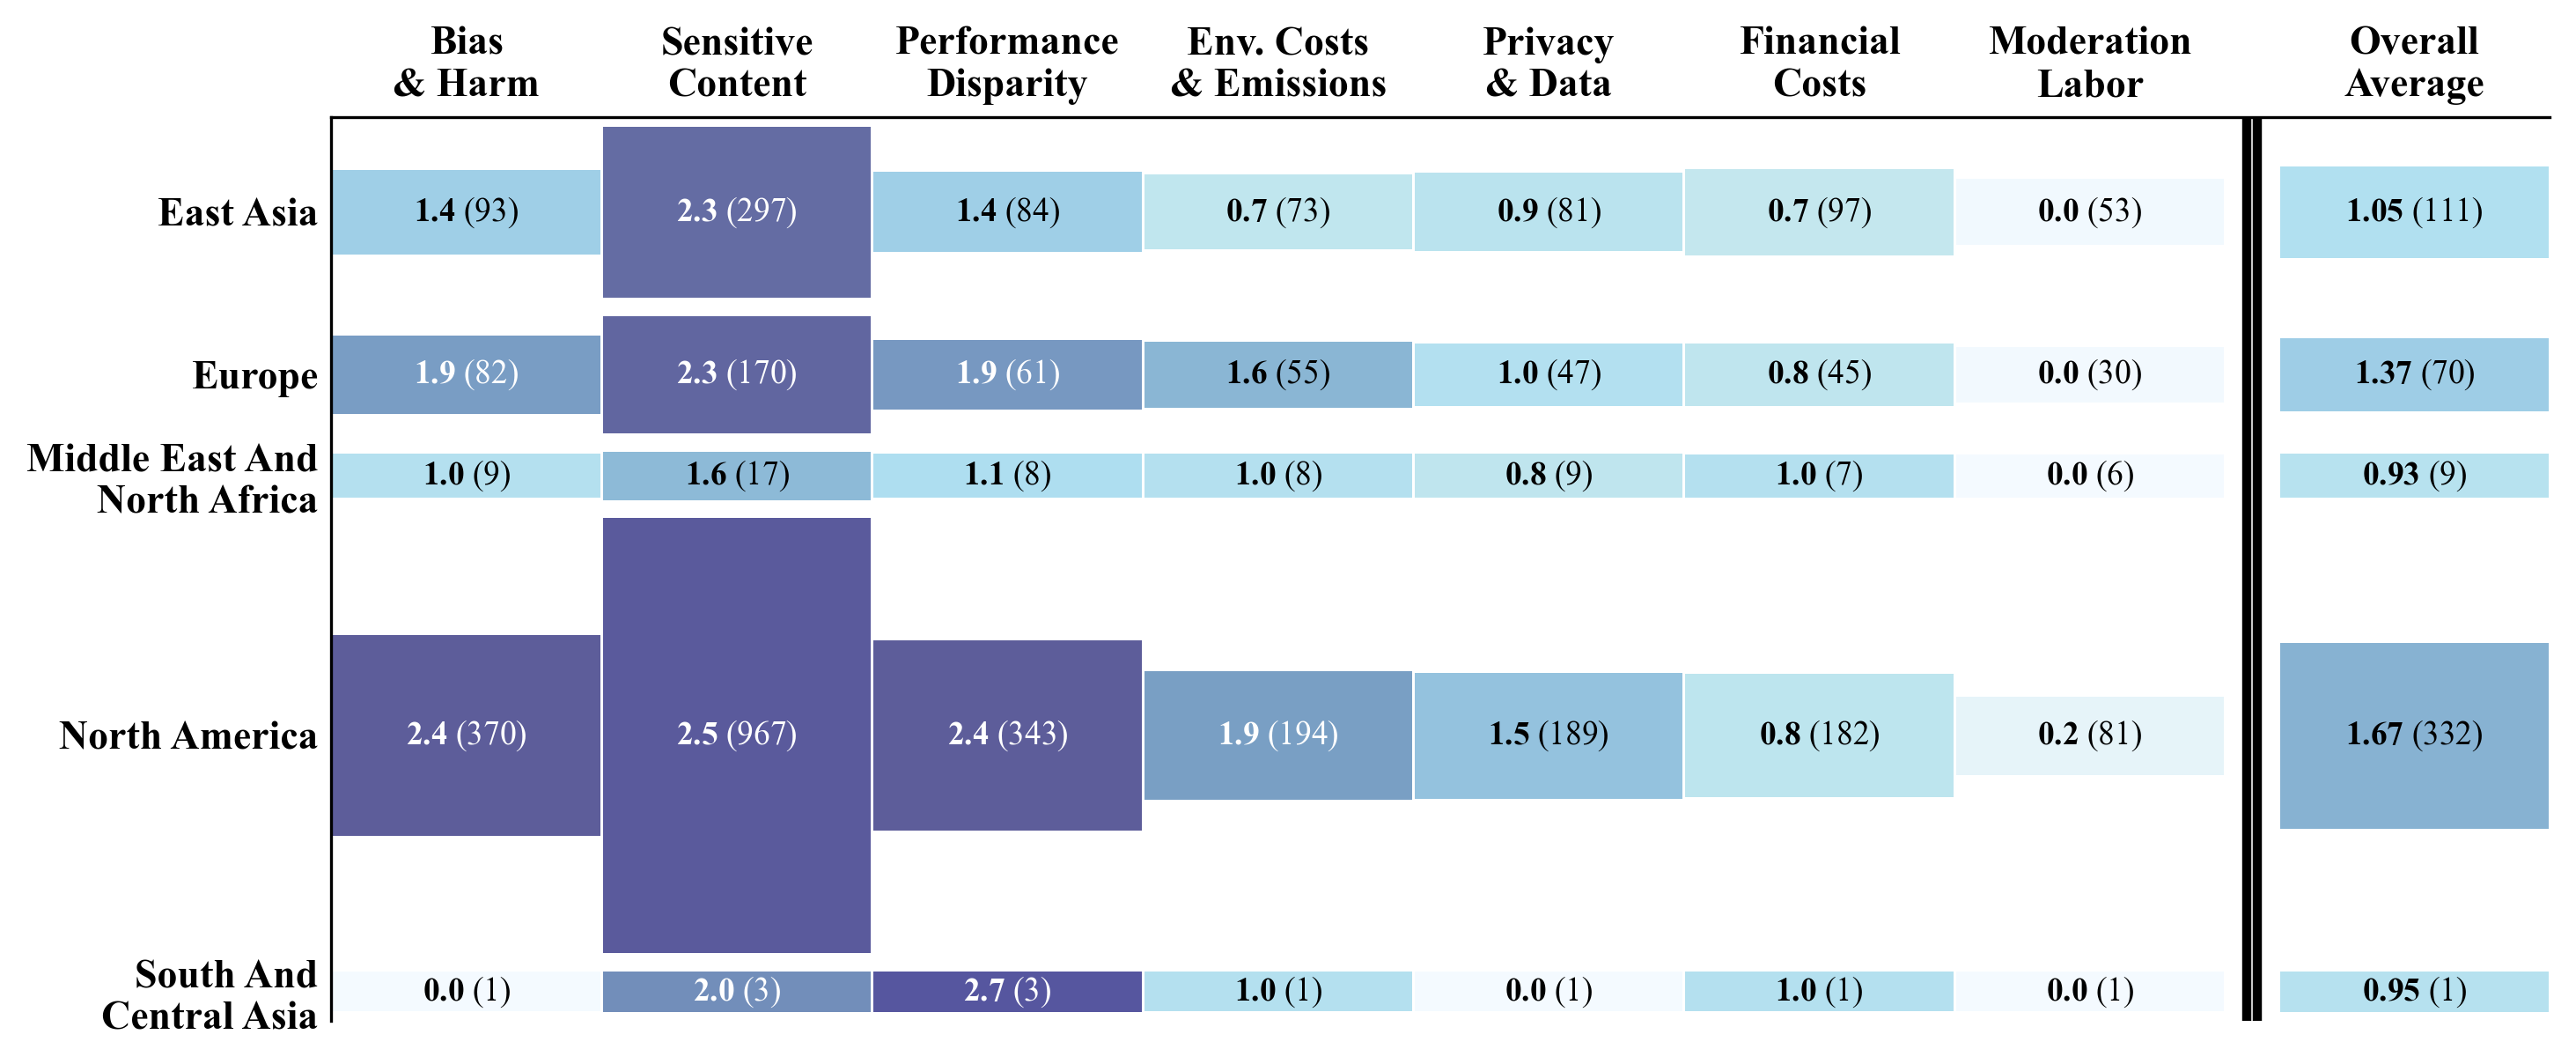

In [ ]:
fig = create_rectangle_plot('region',
                           fig_width=10,
                           fig_height=4.5,
                        #    row_gap=0.65,
                           min_rect_height=0.11,
                           max_rect_height=1.2,
                           rect_width=0.99,
                           power_scale=0.93,
                            row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)
plt.savefig("evaluations_by_region.pdf", bbox_inches="tight")
plt.show()

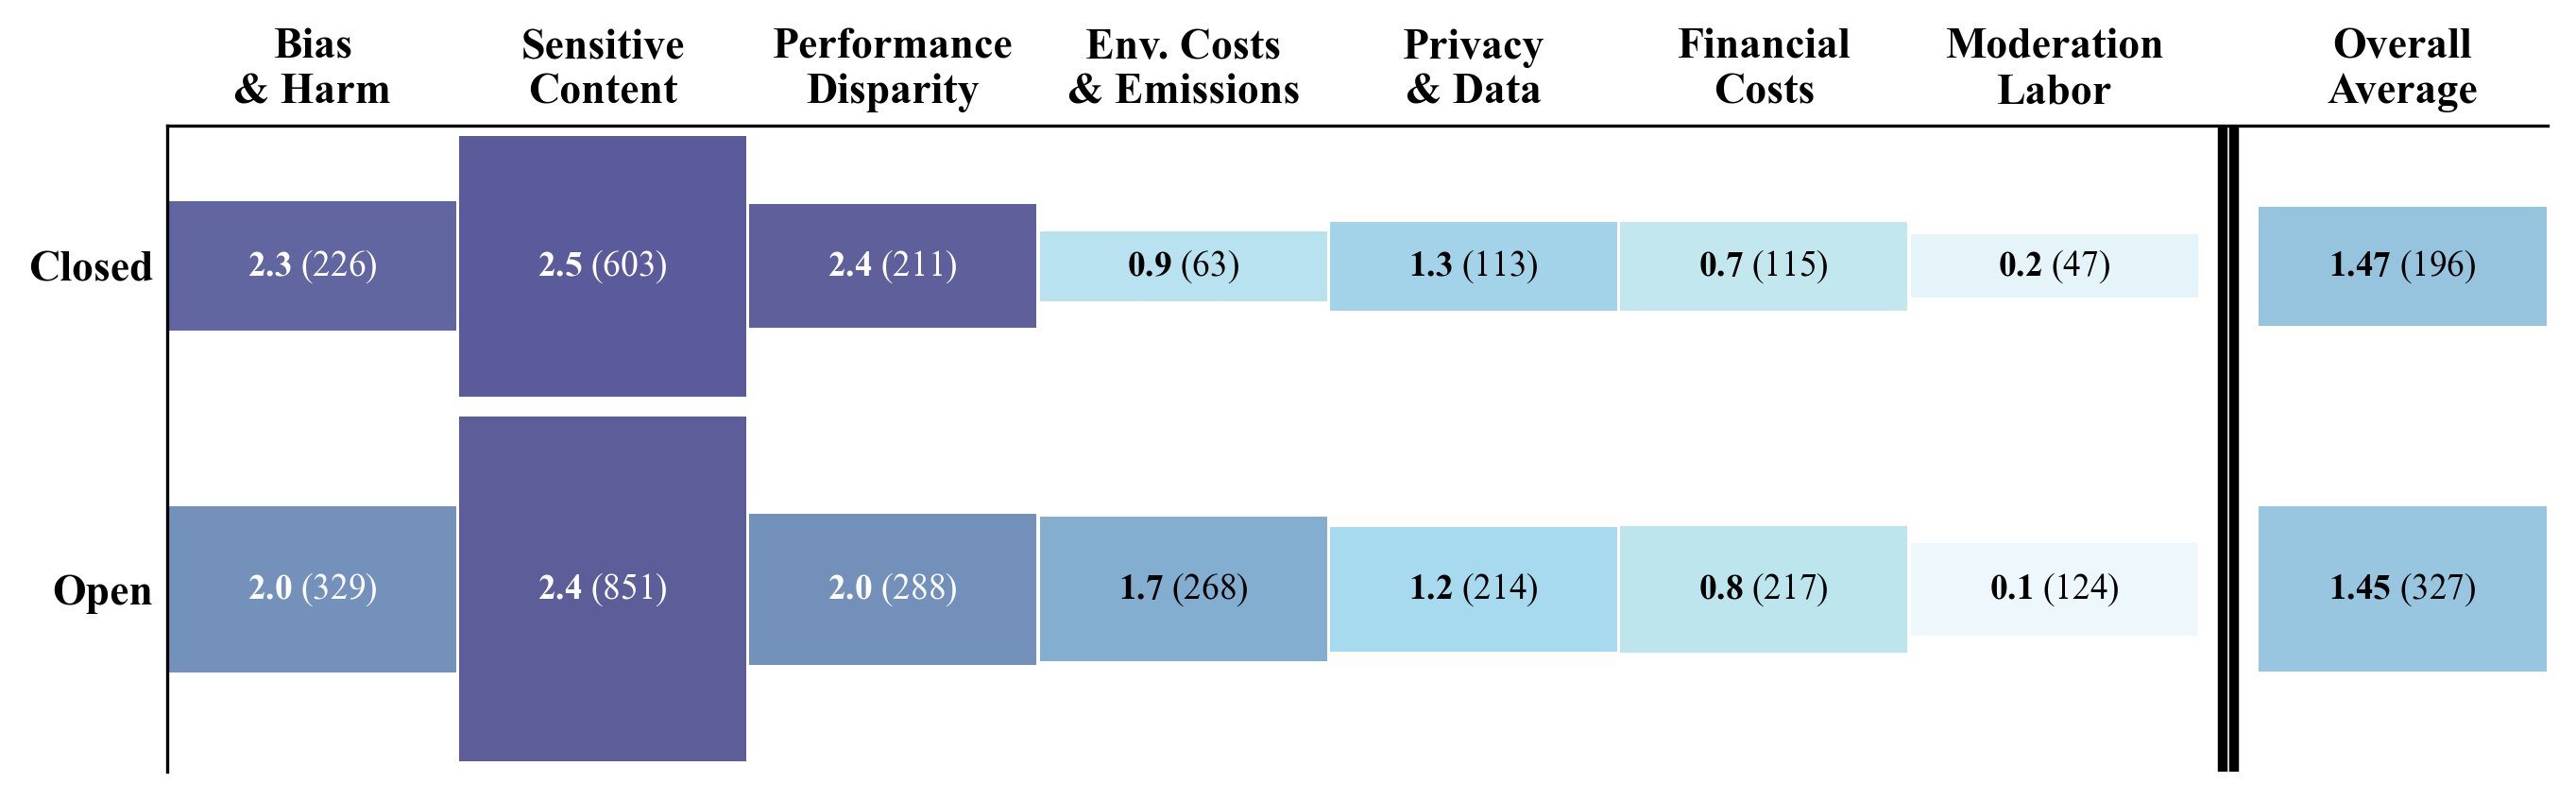

In [ ]:
fig = create_rectangle_plot('openness',
                           fig_width=10,
                           fig_height=3,
                        #    row_gap=0.8,
                           min_rect_height=0.11,
                           max_rect_height=0.85,
                           rect_width=0.99,
                           power_scale=0.95,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_openness.pdf", bbox_inches="tight")
plt.show()

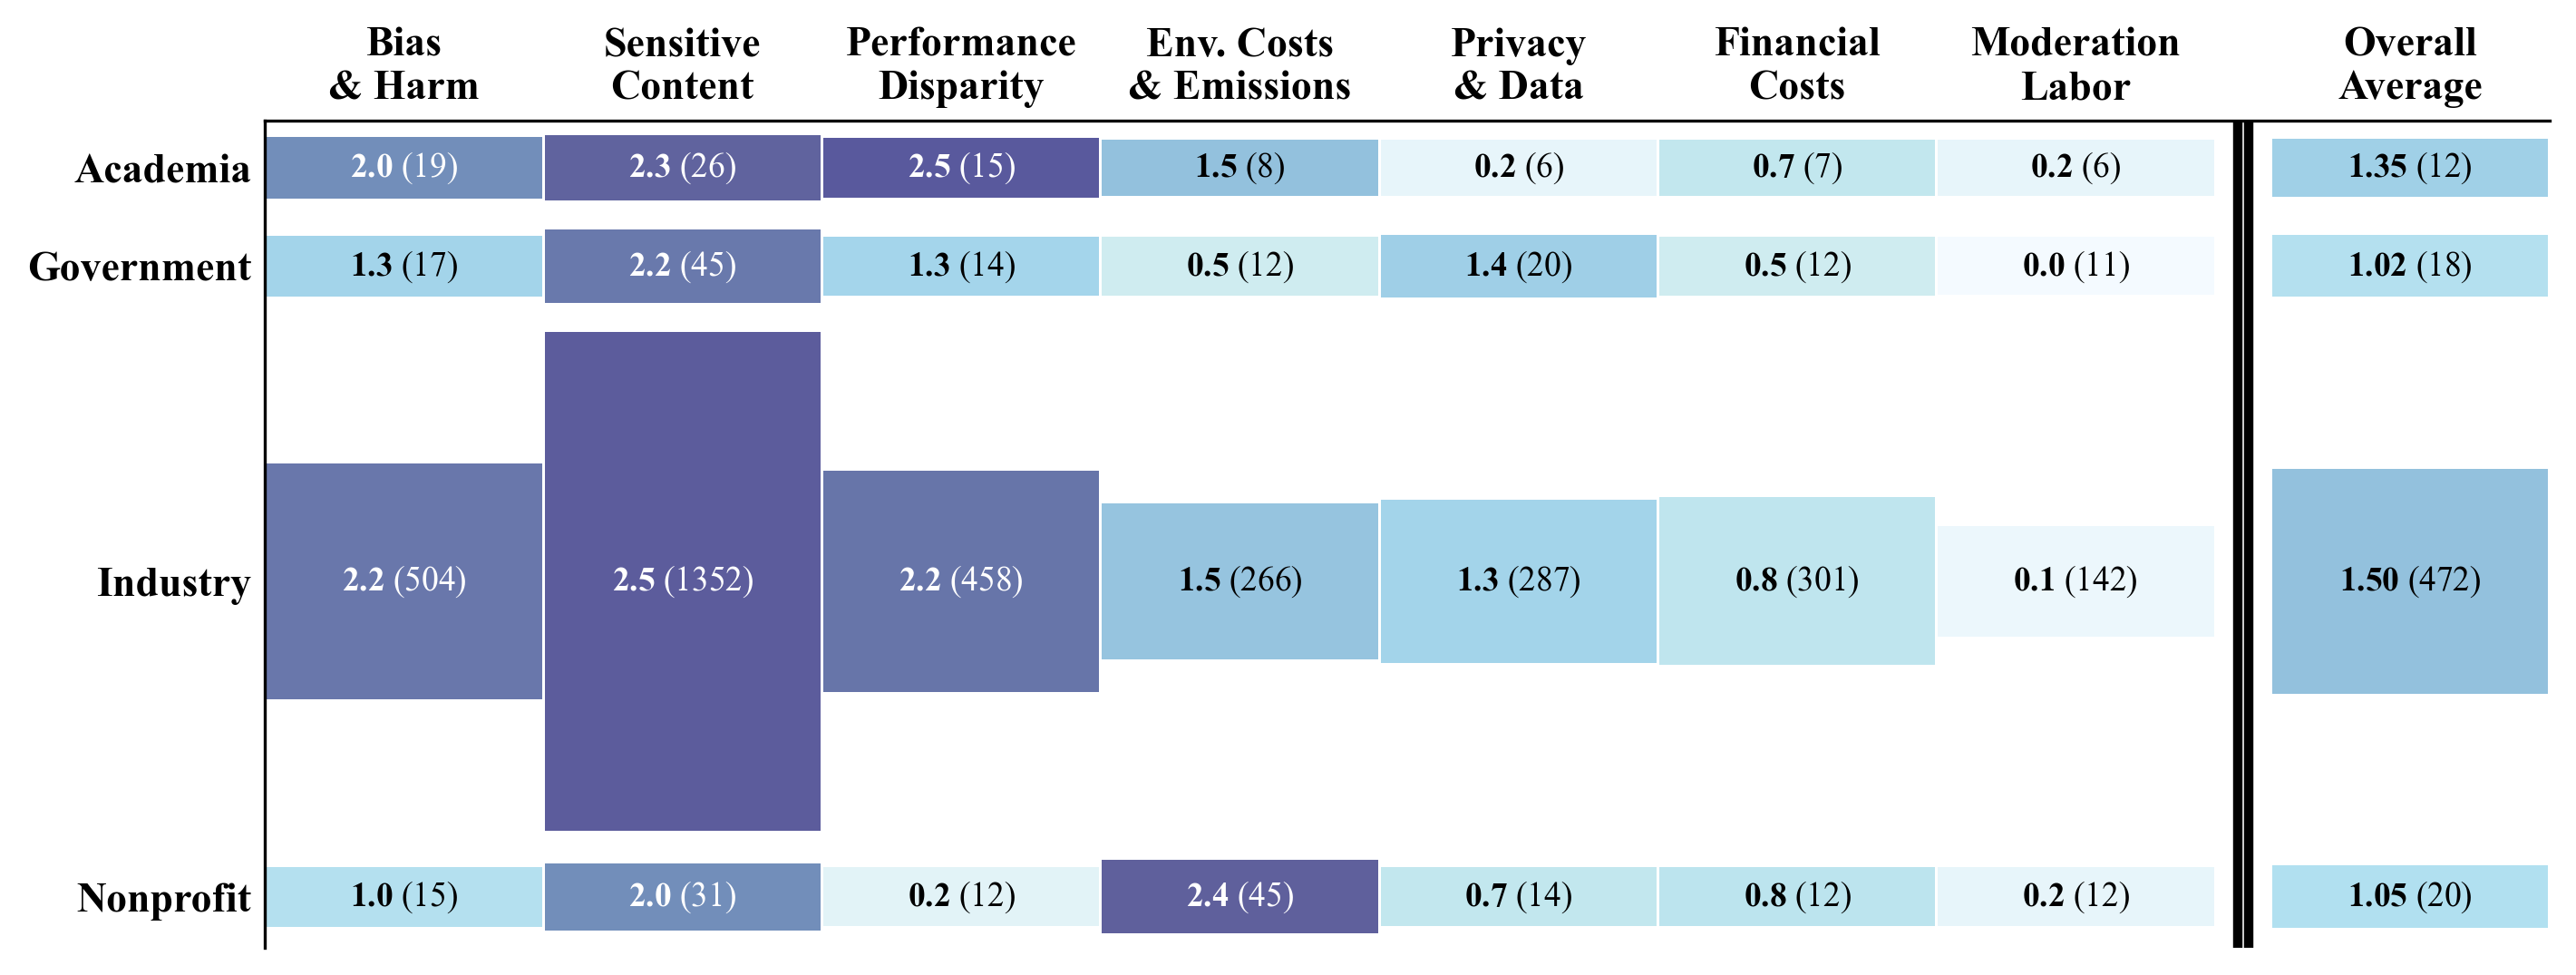

In [ ]:
fig = create_rectangle_plot('sector',
                           fig_width=10,
                           fig_height=4,
                        #    row_gap=0.5,
                           min_rect_height=0.09,
                           max_rect_height=0.85,
                           rect_width=0.99,
                           power_scale=0.9,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_sector.pdf", bbox_inches="tight")
plt.show()

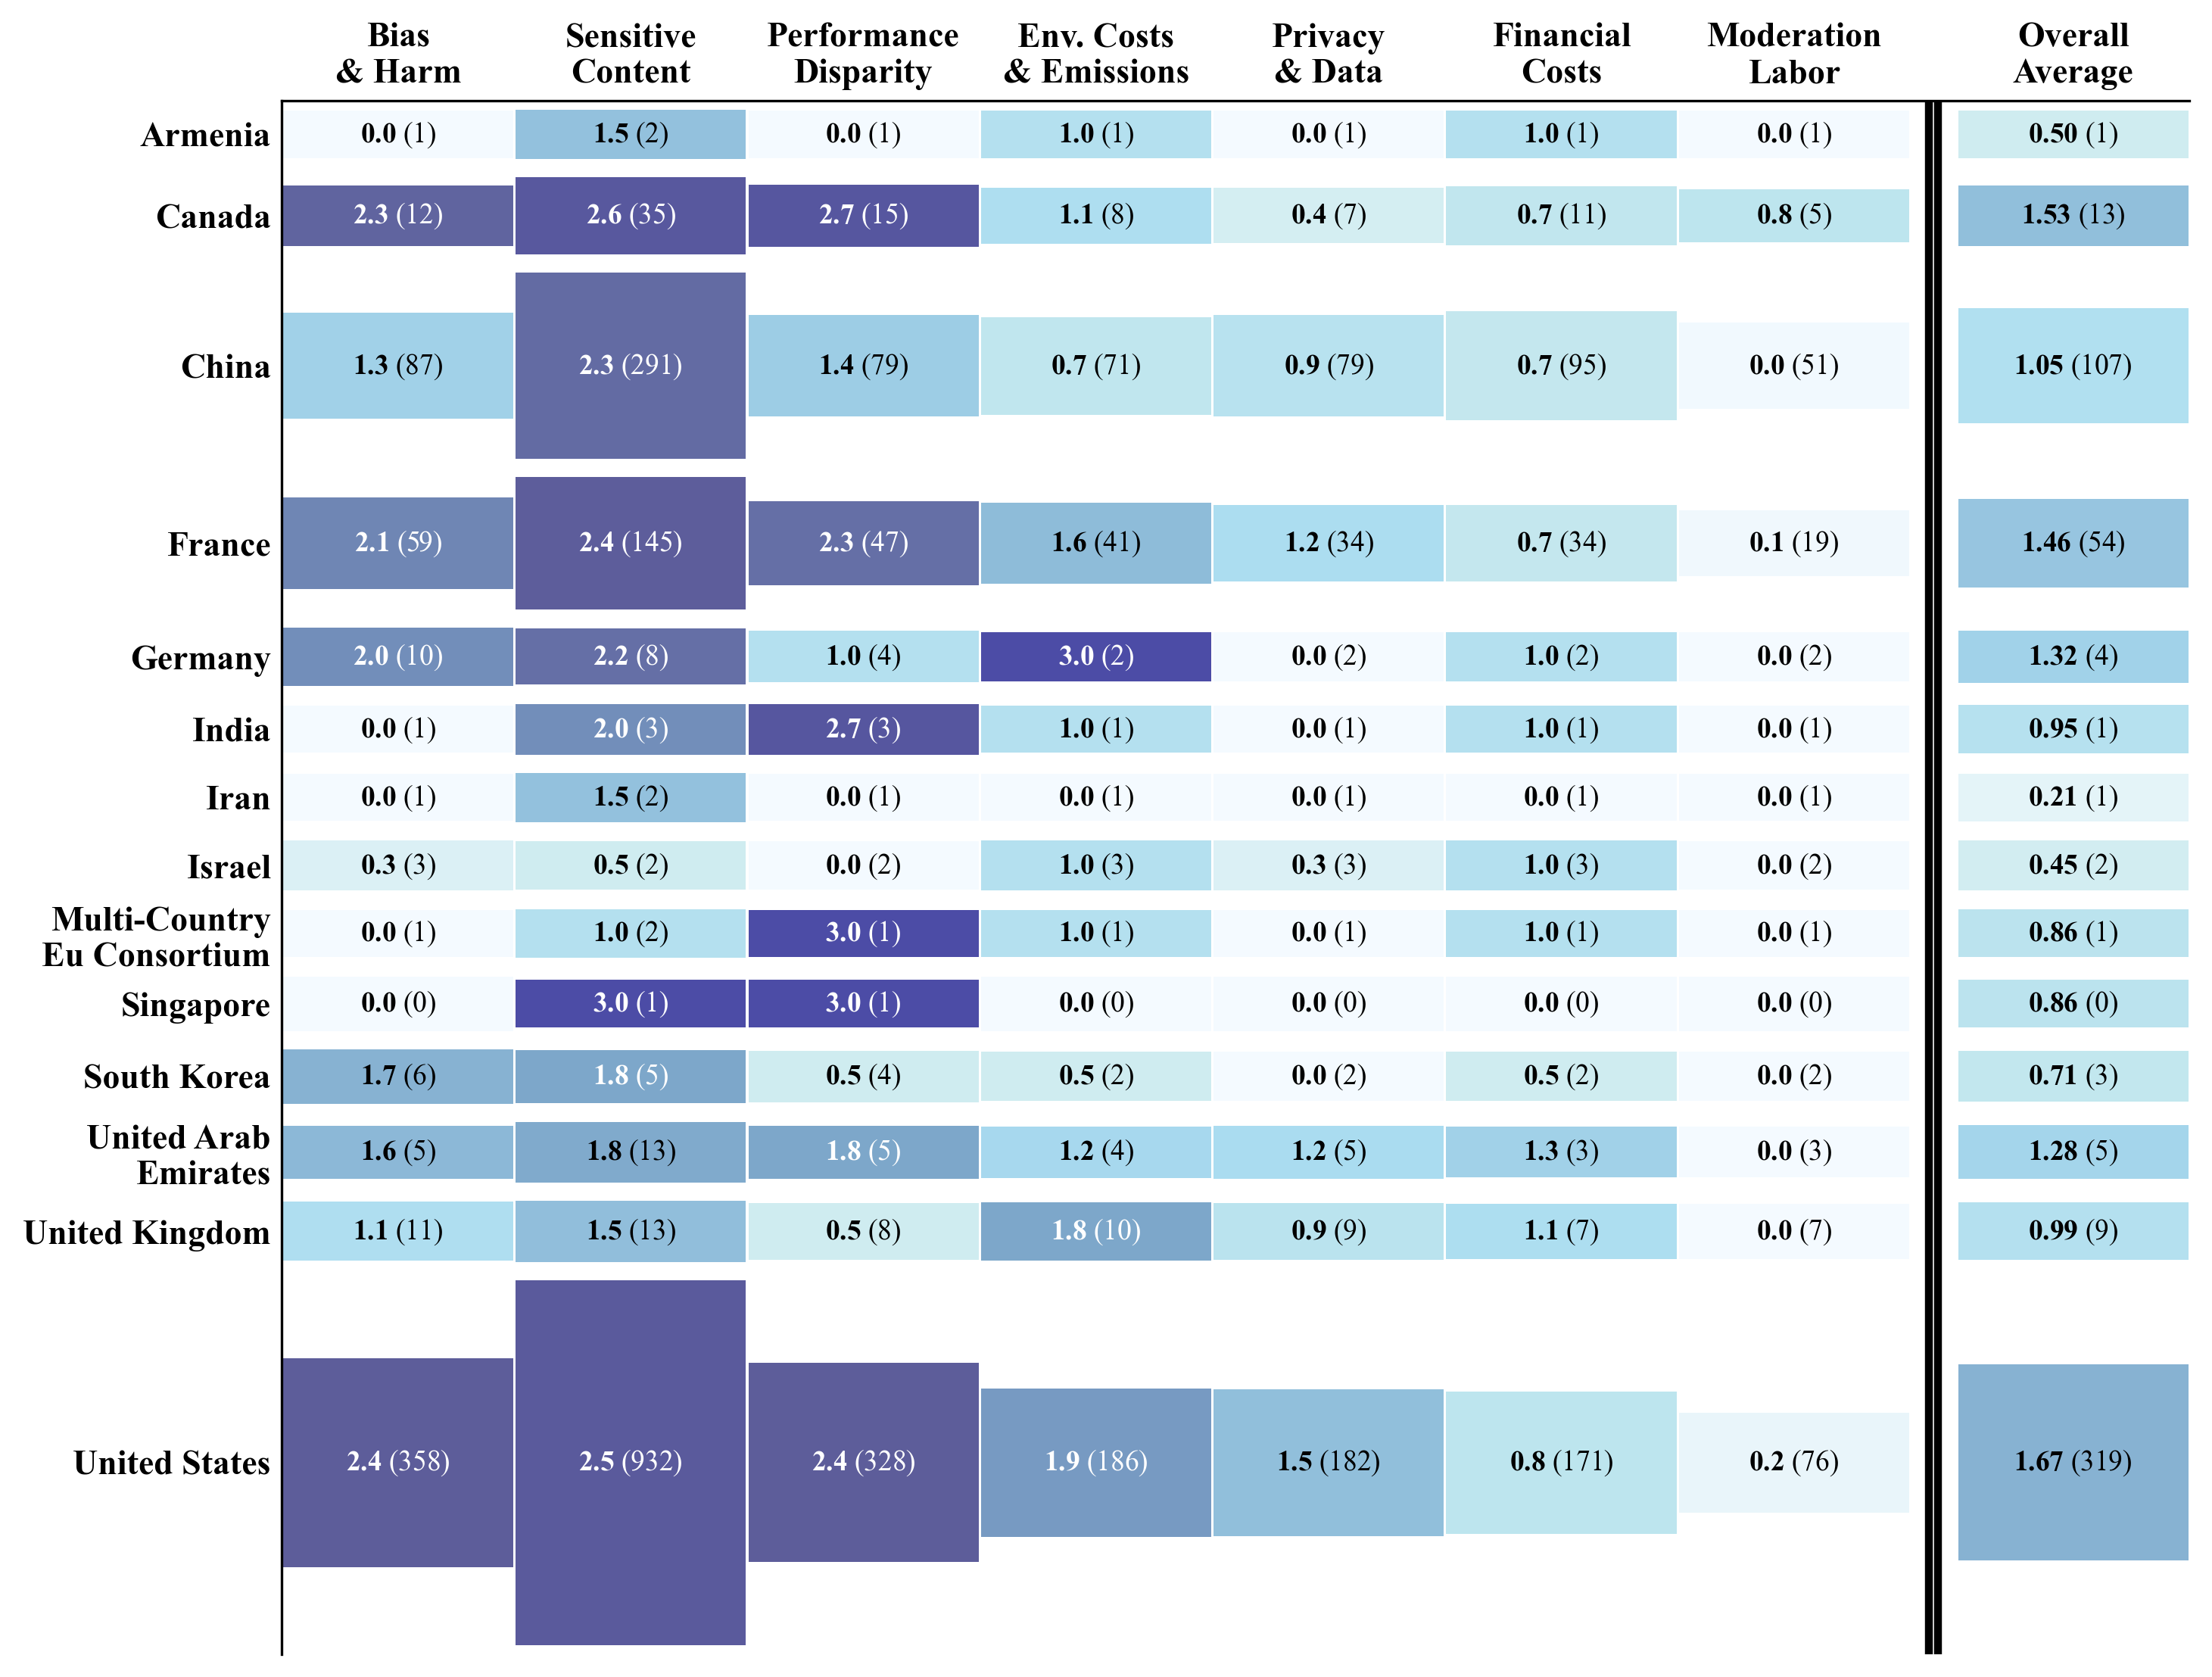

In [ ]:
fig = create_rectangle_plot('country',
                           fig_width=10,
                           fig_height=9,
                        #    row_gap=0.63,
                           min_rect_height=0.13,
                           max_rect_height=1.0,
                           rect_width=0.99,
                           power_scale=0.7,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_country.pdf", bbox_inches="tight")
plt.show()

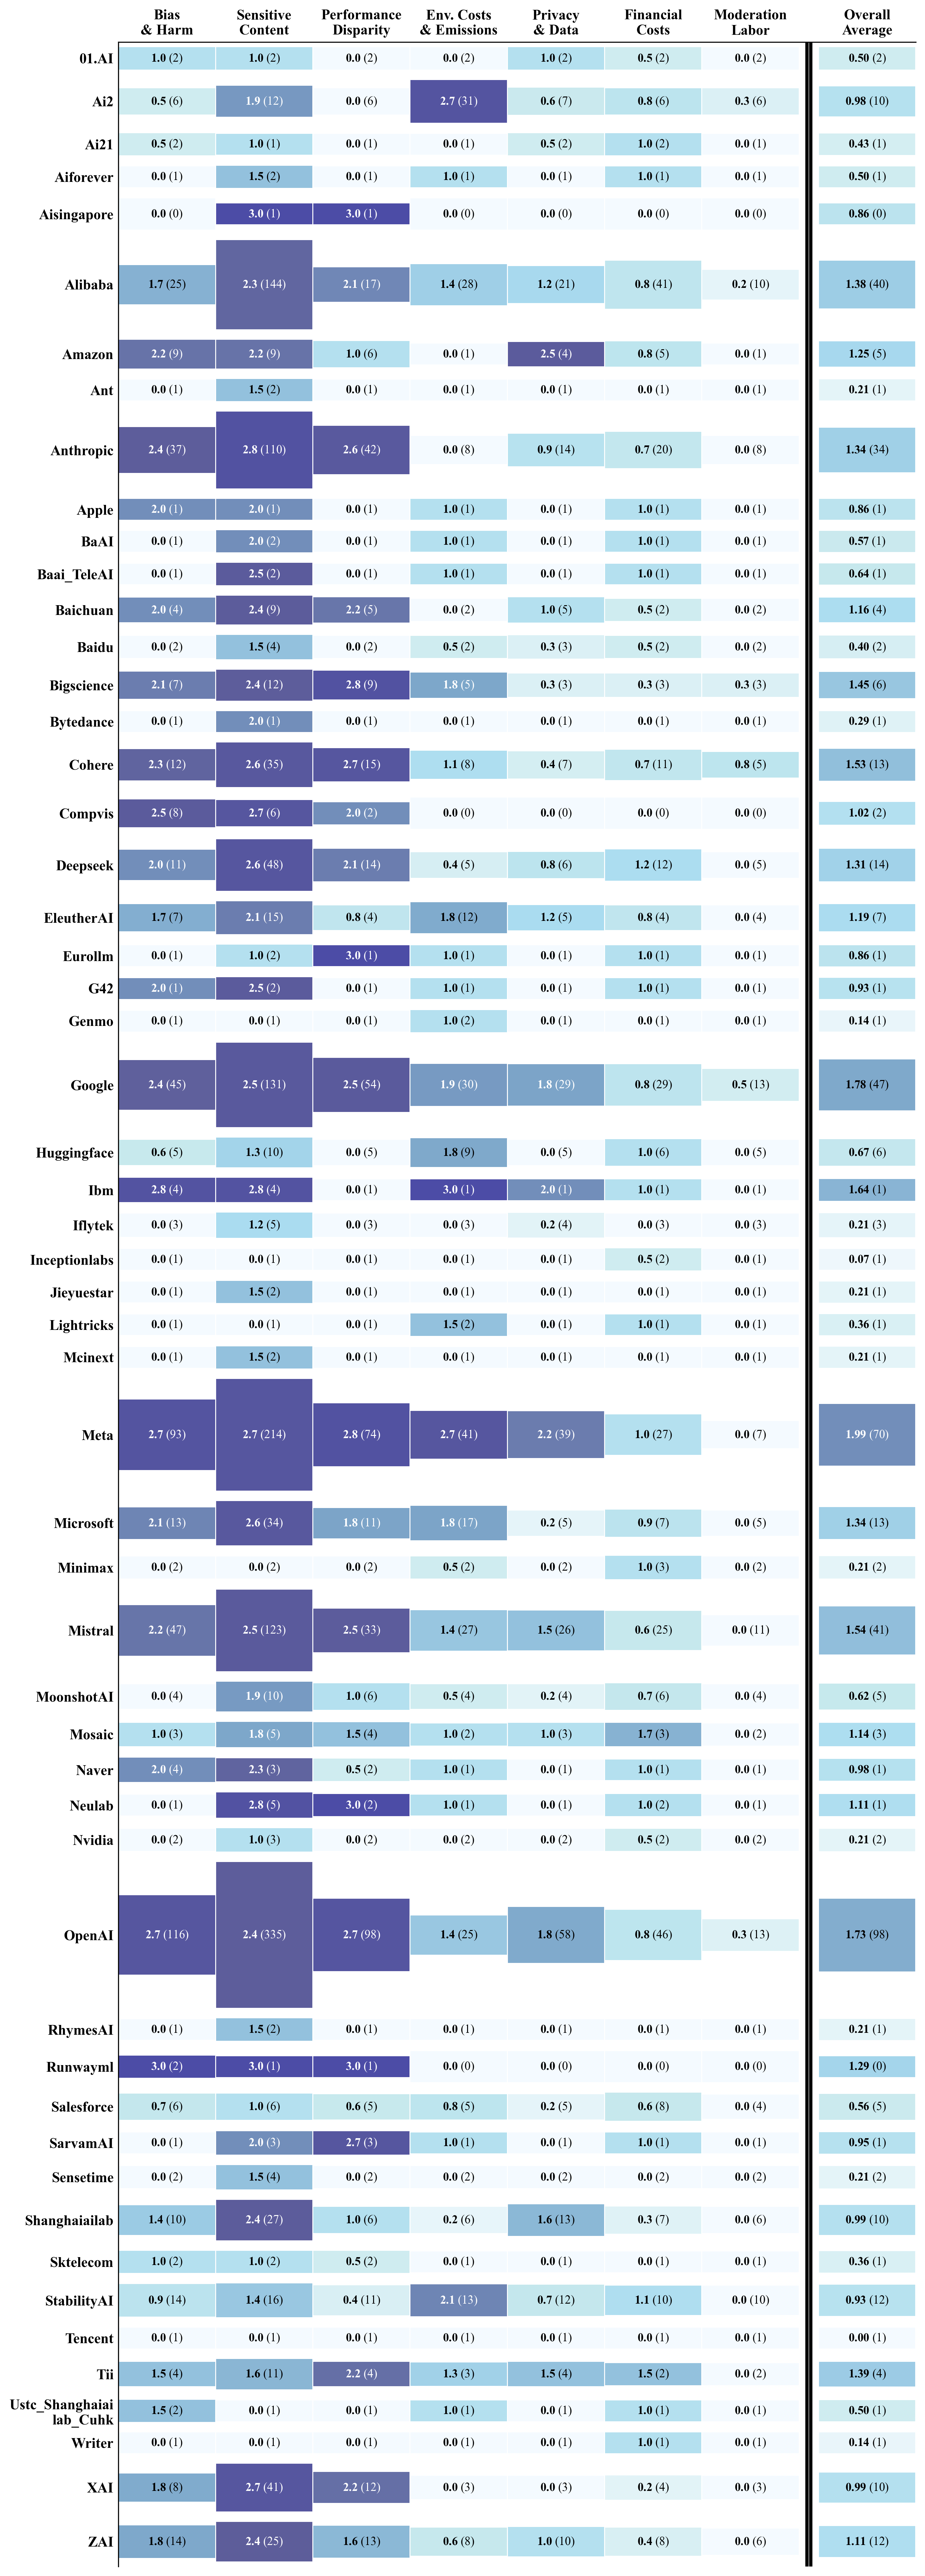

In [ ]:
fig = create_rectangle_plot('provider',
                           fig_width=10,
                           fig_height=35,
                        #    row_gap=0.45,
                           min_rect_height=0.1,
                           max_rect_height=0.7,
                           rect_width=0.99,
                           power_scale=0.7,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_provider.pdf", bbox_inches="tight")
plt.show()

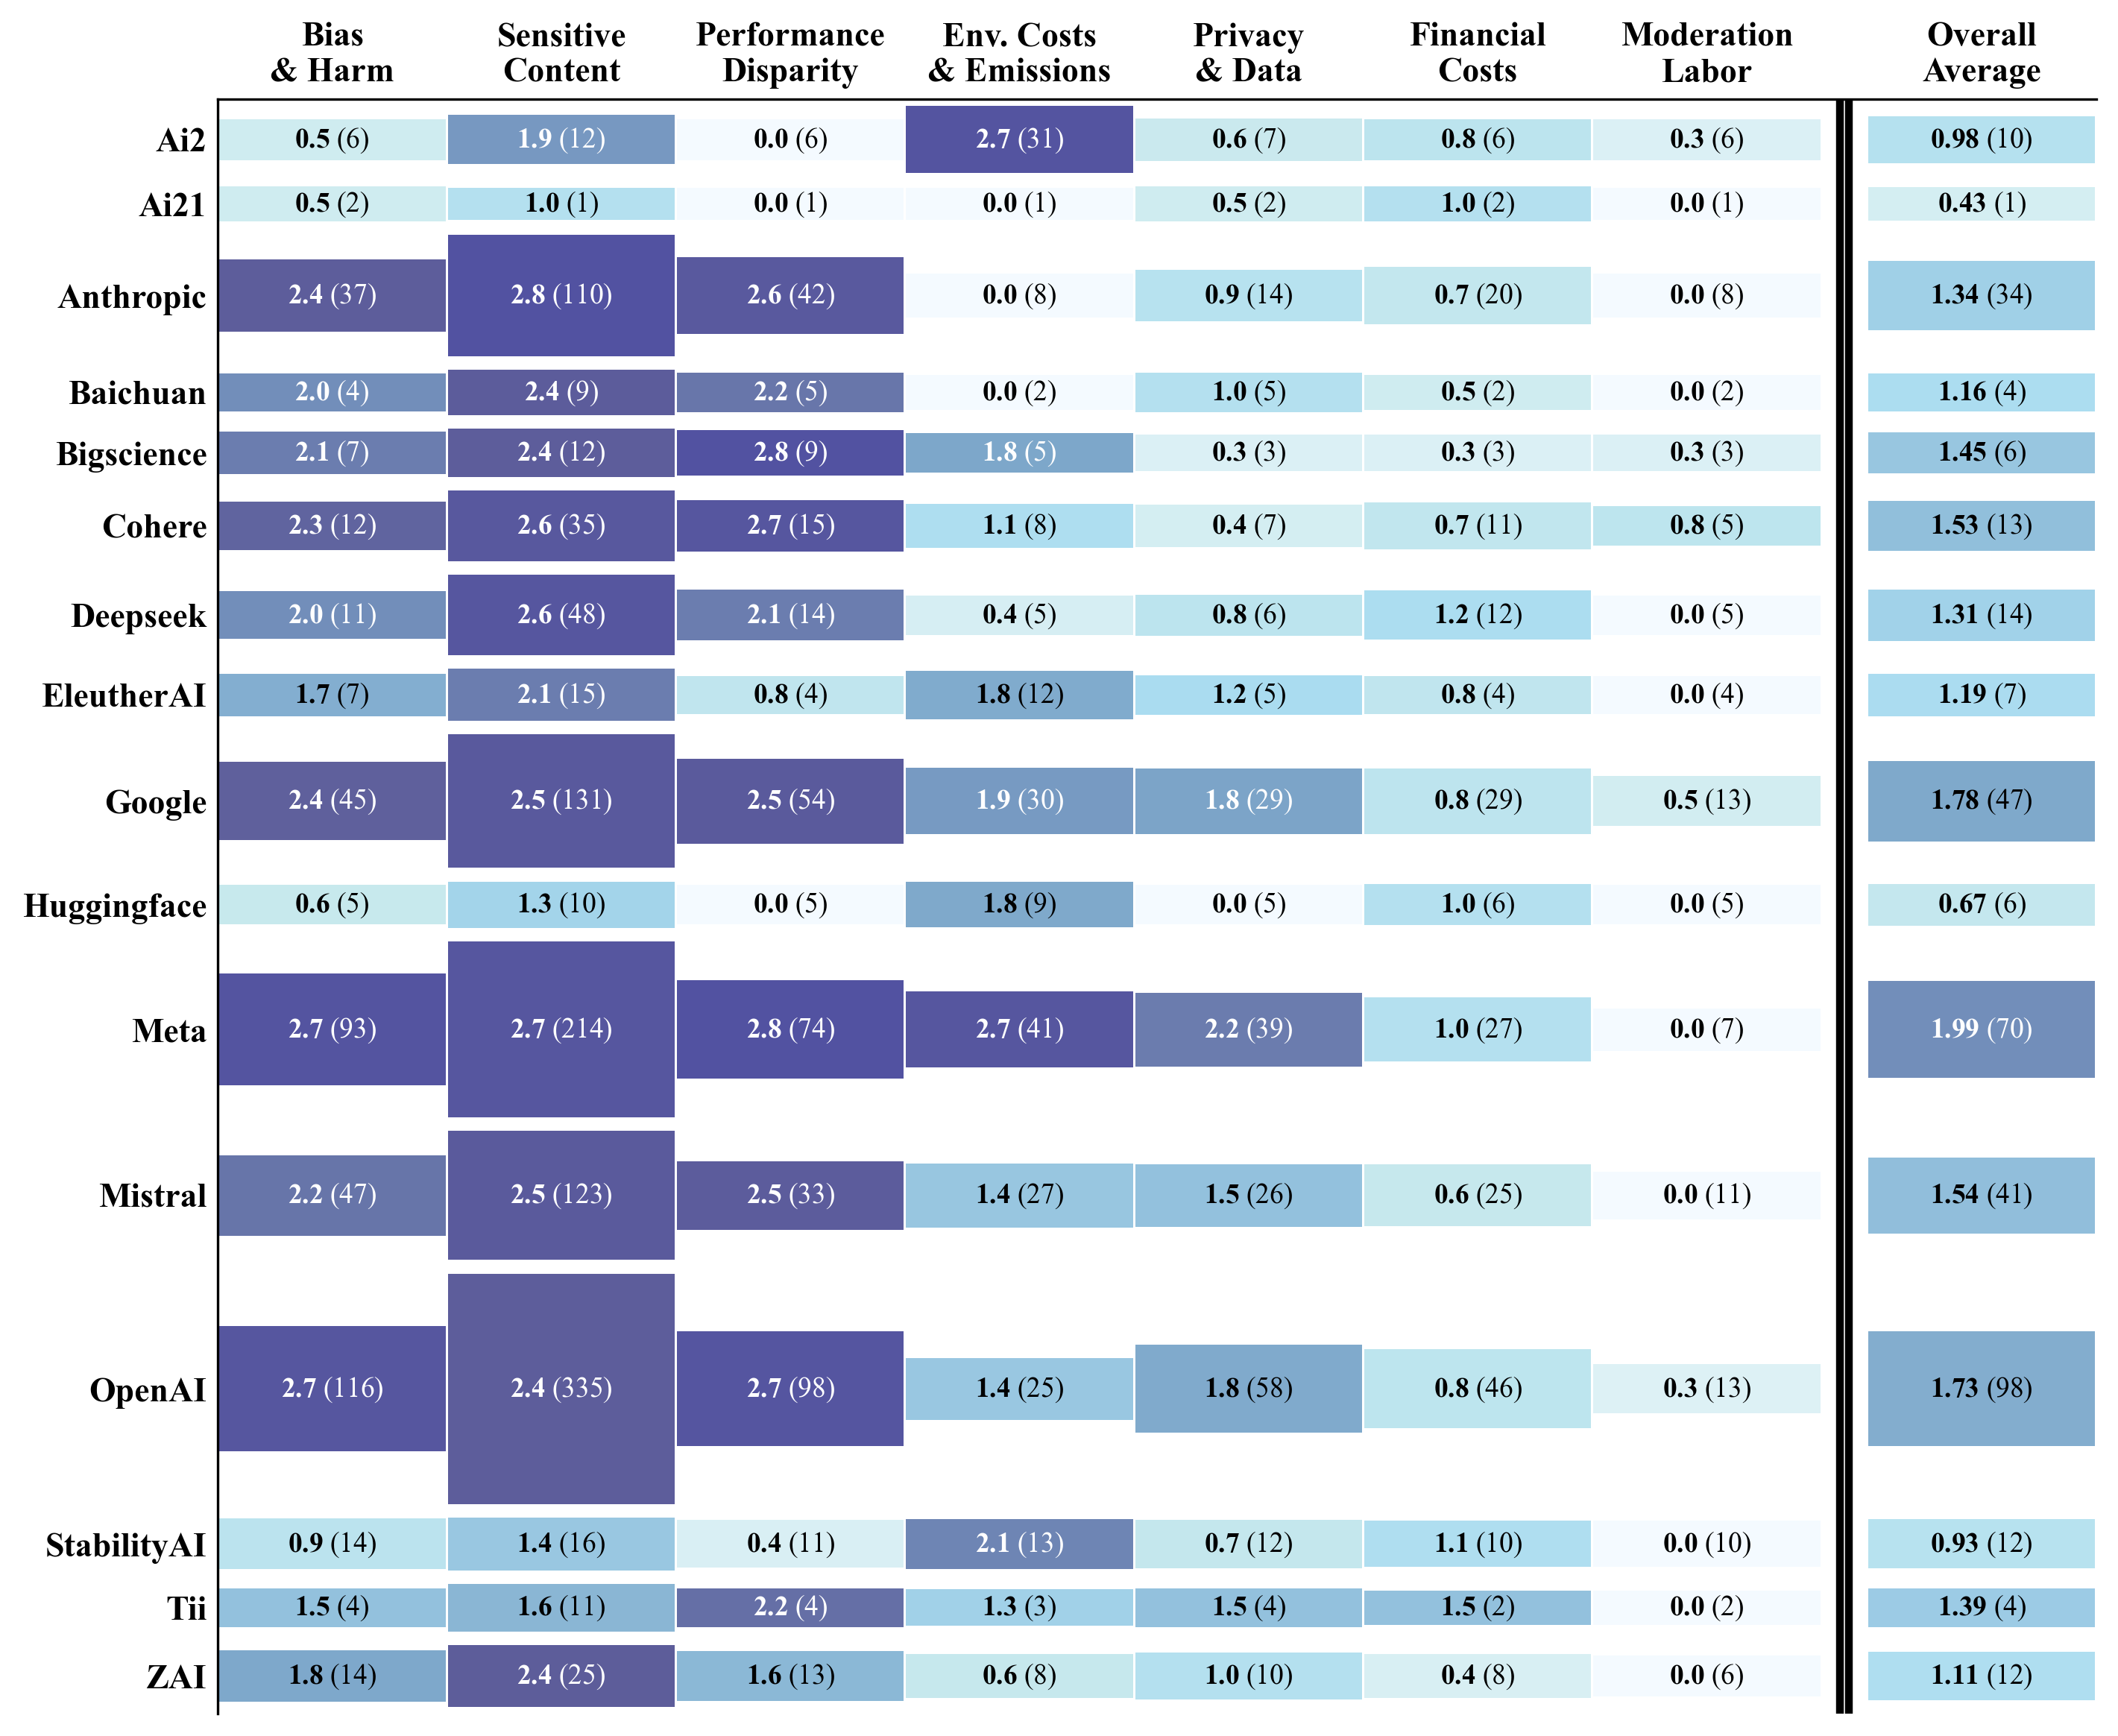

In [ ]:
companies = [
    "ai2", "ai21", "anthropic", "baichuan", "bigScience",
    "cohere", "deepSeek", "eleutherAi", "google", "huggingFace",
    "meta", "mistral", "openAi", "stabilityAi", "tii", "zAi"
]


fig = create_rectangle_plot('provider',
                           fig_width=10,
                           fig_height=9.5,
                        #    row_gap=0.7,
                           min_rect_height=0.12,
                           max_rect_height=0.85,
                           rect_width=0.99,
                           power_scale=0.7,
                           provider_list=companies,
                           row_gap=0.05,
                            separator_gap = 0.2,
                            show_rect_borders=False,
                            show_empty_cells=True,
                           show_quality_scores=True)

plt.savefig("evaluations_by_provider_selected.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Debug code to check what's happening with the data
# Add this right after the plot_data is created in your main function

# Load and process data the same way as in the function
data_df = pd.read_csv("MAIN_ANNOTATIONS_MERGED.tsv", sep="\t")
data_df.columns = [c.strip() for c in data_df.columns]

df_clean = data_df.copy()
df_clean["category"] = pd.to_numeric(df_clean["category"], errors="coerce").astype("Int64")
df_clean["score"] = pd.to_numeric(df_clean["score"], errors="coerce")

df_clean = df_clean[
    df_clean["category"].isin(range(1, 8)) &
    df_clean["score"].between(0, 3, inclusive="both") &
    df_clean["region"].notna()
].copy()

# Aggregate data
model_cat = (
    df_clean.groupby(["provider", "name", "category", "region"], dropna=True)
    .agg(model_eval_count=("score", "size"),
         model_avg_score=("score", "mean"))
    .reset_index()
)

# Final aggregation by region and category
prov_cat_counts = (
    model_cat.groupby(["region", "category"], dropna=True)["model_eval_count"]
    .sum().rename("count").reset_index()
)

print("Top 10 region-category combinations by count:")
top_counts = prov_cat_counts.nlargest(10, 'count')
print(top_counts)

print(f"\nMaximum count value: {prov_cat_counts['count'].max()}")
print(f"Minimum count value: {prov_cat_counts['count'].min()}")

# Check which one has the maximum count
max_count_row = prov_cat_counts.loc[prov_cat_counts['count'].idxmax()]
print(f"\nHighest count is: {max_count_row['region']} x Category {max_count_row['category']} = {max_count_row['count']} evaluations")

# Check North America x Sensitive Content specifically
na_sensitive = prov_cat_counts[(prov_cat_counts['region'] == 'North America') & (prov_cat_counts['category'] == 2)]
if not na_sensitive.empty:
    print(f"North America x Sensitive Content: {na_sensitive['count'].iloc[0]} evaluations")
else:
    print("North America x Sensitive Content: No data found")

Top 10 region-category combinations by count:
           region  category  count
22  North America         2    967
21  North America         1    370
23  North America         3    343
1       East Asia         2    297
24  North America         4    194
25  North America         5    189
26  North America         6    182
8          Europe         2    170
5       East Asia         6     97
0       East Asia         1     93

Maximum count value: 967
Minimum count value: 1

Highest count is: North America x Category 2 = 967 evaluations
North America x Sensitive Content: 967 evaluations
